In [71]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.integrate import quad
from scipy import optimize
import pickle
from IPython.display import Image

# Seed and random generator
np.random.seed(123456)
from numpy.random import Generator, PCG64
rng = Generator(PCG64())

# Fixed tolerance for comparisons
EPSILON: float = 1e-8

# Implemented classes
from simulator import EulerMaruyama, Milstein, RungeKutta
from utils import plot_simulation, plot_white_shot, pdf


In [72]:

# Model Parameters
r0 = 0.17
p = 0.5
k = 1.5
h = 1.2
beta = 0.5
theta = 0.6
alpha = 0.24
m = 0.34

# Noise parameters
sigma = np.array([
    [0.6, 1e-2],
    [1e-2, 1e-2]
])

In [73]:
# Drift function
def f(x, t):
    u, v = x
    f_u = ((r0*u) / (1 + k*alpha*v)) - beta*(u**2) - (((p + alpha*v)*u*v) / (1 + h*(p + alpha*v)*u))
    f_v = ((theta*(p + alpha*v)*u*v) / (1 + h*(p + alpha*v)*u)) - m*v
    return np.array([f_u, f_v])

# Diffusion function
def g(x, t):
    u, v = x
    g_u = u*(sigma[0,0] + sigma[0, 1]*u)
    g_v = v*(sigma[1,0] + sigma[1, 1]*v)
    return np.array([g_u, g_v])

# First derivatives of diffusion function
def dg(x, t):
    u, v = x
    dg_u = sigma[0, 0] + 2*sigma[0, 1]*u
    dg_v = sigma[1, 0] + 2*sigma[1, 1]*v
    return np.array([dg_u, dg_v])


In [74]:
u = 2.3075
v = 1.1143
x_eq = np.array([u, v])

# Simulation variables
x0 = np.array([3.6, 2.4])   # Initial [prey, predator] densities
# x0 = x_eq
T = 100                     # Total simulation time
N = 10_000                  # Number of time steps

# Select simulator
simulator = Milstein(x0, T, N, f, g, dg)

# Run simulation 
x, t = simulator.simulate()

# Simulate deterministic system as well
x_det, t_det = simulator.simulate_deterministic()

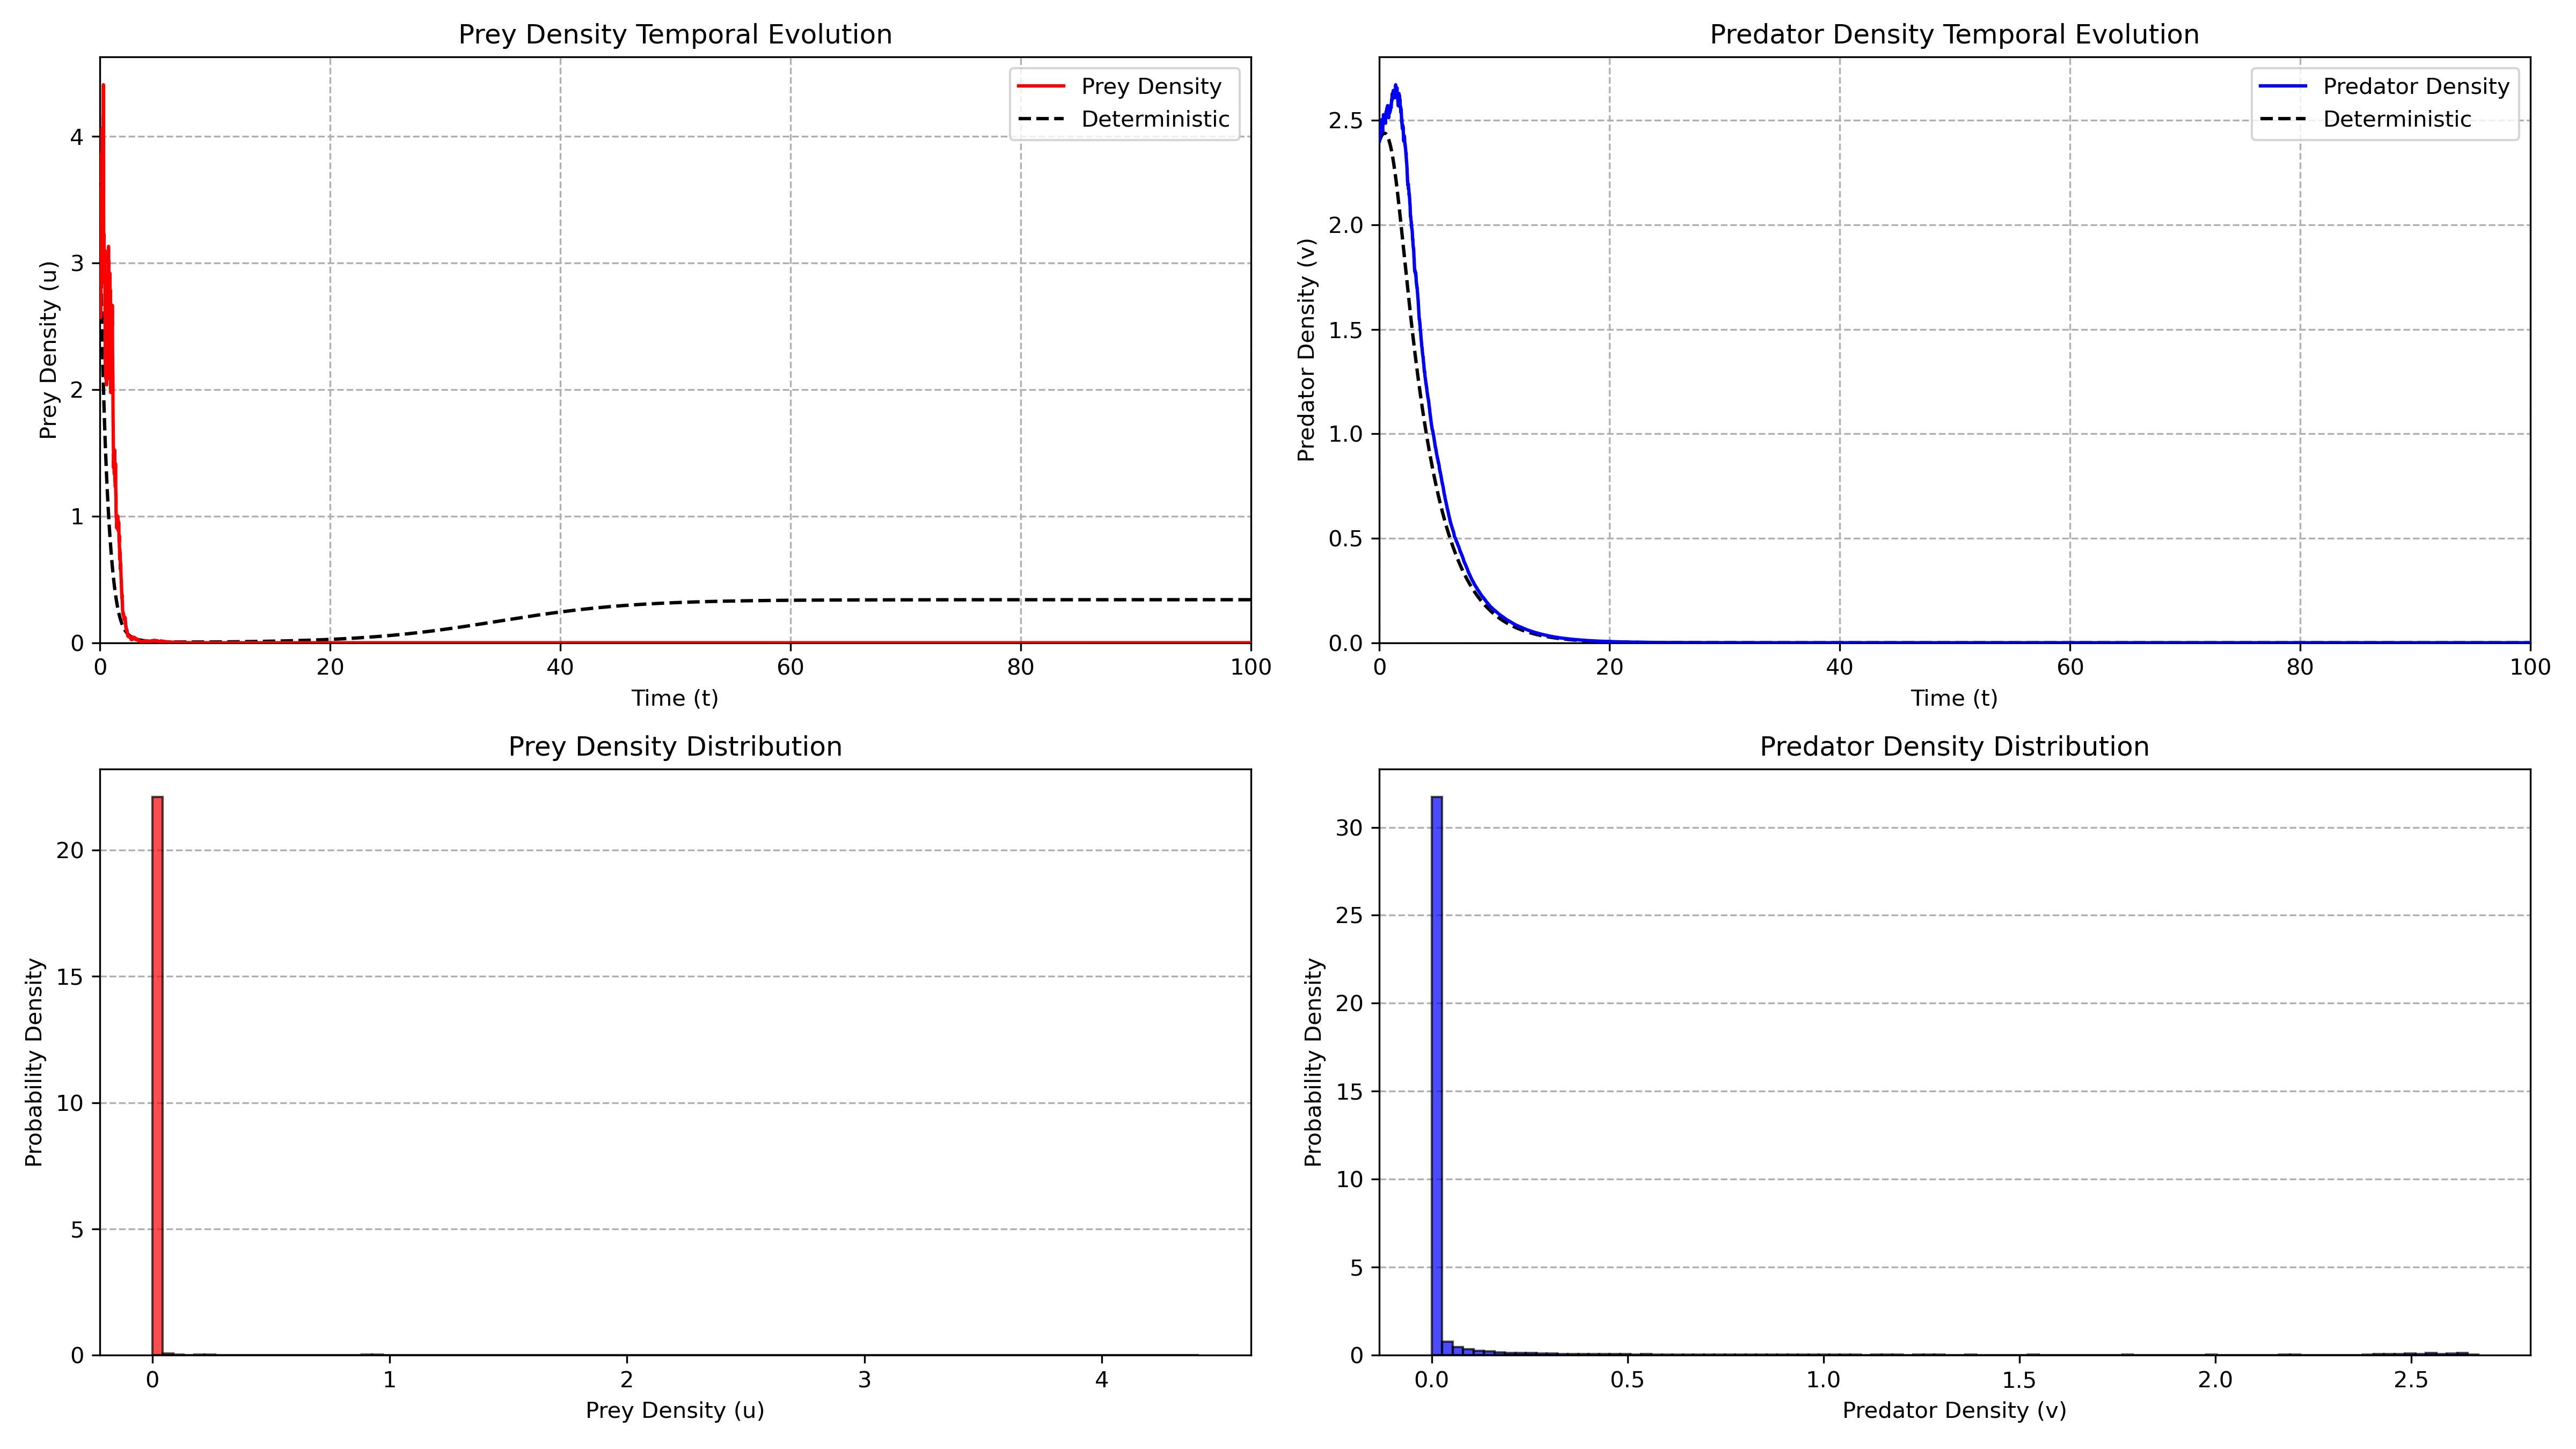

In [75]:

# Compute pdf 
u_pdf, u_bins, v_pdf, v_bins = pdf(x)

# Create plot figure and axes
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Prey temporal evolution
ax[0,0].plot(t, x[:, 0], label='Prey Density', color='red', zorder=3)
if x_det is not None and t_det is not None:
    ax[0,0].plot(t_det, x_det[:, 0], label='Deterministic', color='black', linestyle='--', zorder=2)
ax[0,0].set_title('Prey Density Temporal Evolution')
ax[0,0].set_xlabel('Time (t)')
ax[0,0].set_ylabel('Prey Density (u)')
ax[0,0].set_xlim(0, T)
ax[0,0].set_ylim(0, None)
ax[0,0].grid(linestyle='--', zorder=1)
ax[0,0].legend()

# Predator temporal evolution
ax[0,1].plot(t, x[:, 1], label='Predator Density', color='blue', zorder=3)
if x_det is not None and t_det is not None:
    ax[0,1].plot(t_det, x_det[:, 1], label='Deterministic', color='black', linestyle='--', zorder=2)
ax[0,1].set_title('Predator Density Temporal Evolution')
ax[0,1].set_xlabel('Time (t)')
ax[0,1].set_ylabel('Predator Density (v)')
ax[0,1].set_xlim(0, T)
ax[0,1].set_ylim(0, None)
ax[0,1].grid(linestyle='--', zorder=1)
ax[0,1].legend()

# Prey PDF
bin_centers = 0.5 * (u_bins[1:] + u_bins[:-1])
ax[1,0].bar(bin_centers, u_pdf, width=(u_bins[1] - u_bins[0]), alpha=0.7, color='red', edgecolor='black', zorder=2)
ax[1,0].set_title('Prey Density Distribution')
ax[1,0].set_xlabel('Prey Density (u)')
ax[1,0].set_ylabel('Probability Density')
ax[1,0].grid(axis='y', linestyle='--', zorder=1)

# Predator density PDF
bin_centers = 0.5 * (v_bins[1:] + v_bins[:-1])
ax[1,1].bar(bin_centers, v_pdf, width=(v_bins[1] - v_bins[0]), alpha=0.7, color='blue', edgecolor='black', zorder=2)
ax[1,1].set_title('Predator Density Distribution')
ax[1,1].set_xlabel('Predator Density (v)')
ax[1,1].set_ylabel('Probability Density')
ax[1,1].grid(axis='y', linestyle='--', zorder=1)

plt.tight_layout()

# Save plot as high resolution image
NAME = 'prey_extinction_simulation'
plt.savefig(f'../docs/images/{NAME}.png', format='png', dpi=300)
plt.close()
display(Image(filename=f"../docs/images/{NAME}.png"))